**Welcome to**

# Sina SEManticSEGmentation Toolkit

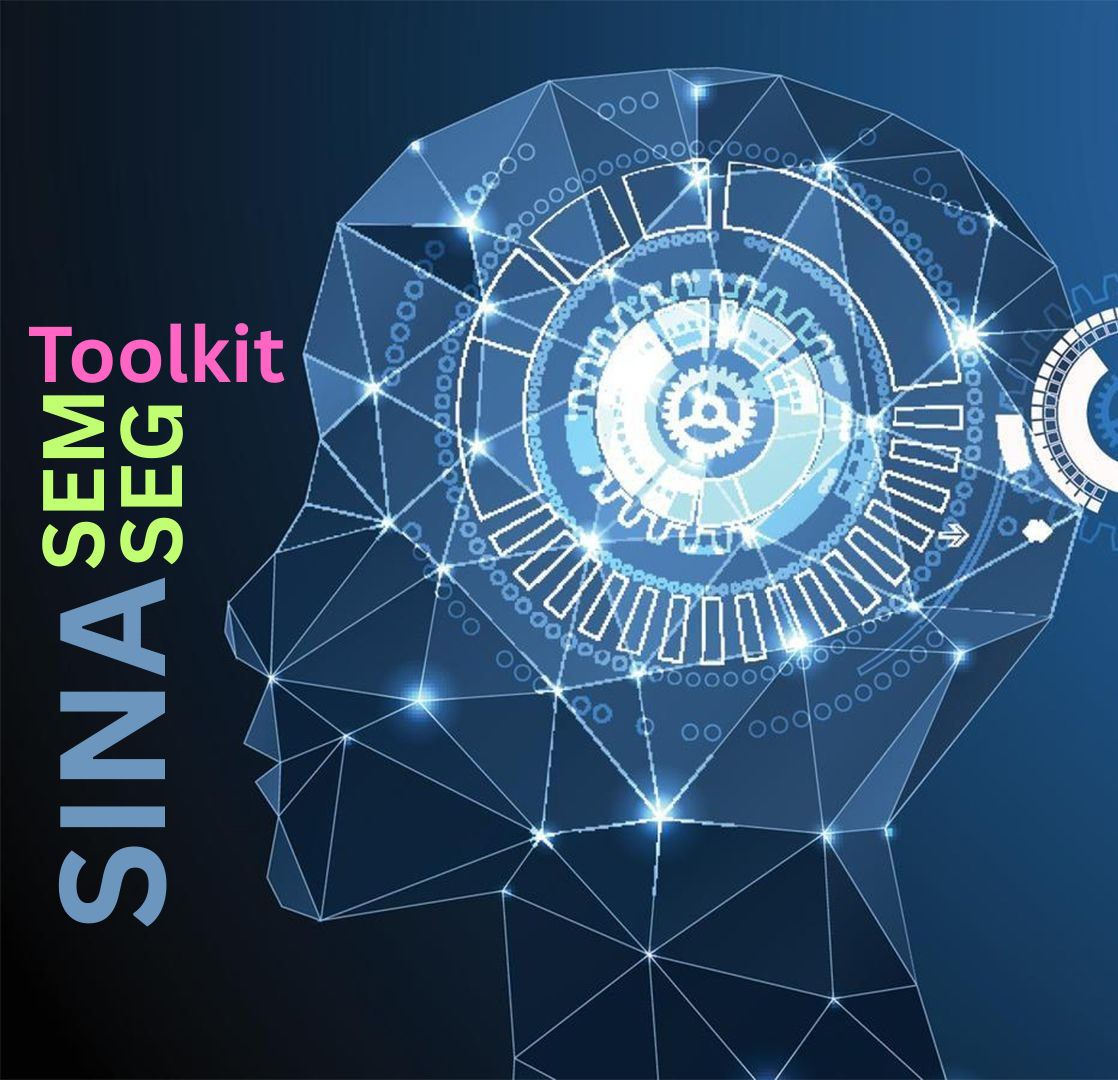

# Installation

In this program, you are able to easily develop semantic segmentation models without programming. To start, you should click on the circle-like button to run the cells.

**RUN ME** before you begin.

In [ ]:

# @title ## Download sources

!pip install segmentation_models
!pip install keras_unet

In [ ]:

# @title ## Automatic Debugger

import os

folders = os.listdir('/usr/local/lib/') ;
matches = [item for item in folders if 'python' in item.lower()]

pythonVersion = (matches[0]) ;

In [ ]:

# @title ## Automatic Debugger 1


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/efficientnet/__init__.py"


new_code = """

import functools
from .__version__ import __version__

_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None


def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def inject_keras_modules(func):
    import keras
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        kwargs['backend'] = keras.backend
        kwargs['layers'] = keras.layers
        kwargs['models'] = keras.models
        kwargs['utils'] = keras.utils
        return func(*args, **kwargs)

    return wrapper


def inject_tfkeras_modules(func):
    import tensorflow.keras as tfkeras
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        kwargs['backend'] = tfkeras.backend
        kwargs['layers'] = tfkeras.layers
        kwargs['models'] = tfkeras.models
        kwargs['utils'] = tfkeras.utils
        return func(*args, **kwargs)

    return wrapper


def init_keras_custom_objects():
    import keras
    from . import model

    custom_objects = {
        'swish': inject_keras_modules(model.get_swish)(),
        'FixedDropout': inject_keras_modules(model.get_dropout)()
    }

    keras.utils.get_custom_objects().update(custom_objects)


def init_tfkeras_custom_objects():
    import tensorflow.keras as tfkeras
    from . import model

    custom_objects = {
        'swish': inject_tfkeras_modules(model.get_swish)(),
        'FixedDropout': inject_tfkeras_modules(model.get_dropout)()
    }

    tfkeras.utils.get_custom_objects().update(custom_objects)

"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;






In [ ]:

# @title ## Automatic Debugger 2

file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/segmentation_models/base/functional.py"   ;



new_code = """

SMOOTH = 1e-5


def _gather_channels(x, indexes, **kwargs):

    backend = kwargs['backend']
    from tensorflow.keras import backend
    if backend.image_data_format() == 'channels_last':
        x = backend.permute_dimensions(x, (3, 0, 1, 2))
        x = backend.gather(x, indexes)
        x = backend.permute_dimensions(x, (1, 2, 3, 0))
    else:
        x = backend.permute_dimensions(x, (1, 0, 2, 3))
        x = backend.gather(x, indexes)
        x = backend.permute_dimensions(x, (1, 0, 2, 3))
    return x


def get_reduce_axes(per_image, **kwargs):
    backend = kwargs['backend']
    axes = [1, 2] if backend.image_data_format() == 'channels_last' else [2, 3]
    if not per_image:
        axes.insert(0, 0)
    return axes


def gather_channels(*xs, indexes=None, **kwargs):
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes, **kwargs) for x in xs]
    return xs


def round_if_needed(x, threshold, **kwargs):
    backend = kwargs['backend']
    from tensorflow.keras import backend
    if threshold is not None:
        x = backend.greater(x, threshold)
        x = backend.cast(x, backend.floatx())
    return x


def average(x, per_image=False, class_weights=None, **kwargs):
    backend = kwargs['backend']
    from tensorflow.keras import backend
    if per_image:
        x = backend.mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return backend.mean(x)


def iou_score(gt, pr, class_weights=1., class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None, **kwargs):


    backend = kwargs['backend']
    from tensorflow.keras import backend


    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    intersection = backend.sum(gt * pr, axis=axes)
    union = backend.sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


def f_score(gt, pr, beta=1, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None,
            **kwargs):


    backend = kwargs['backend']
    from tensorflow.keras import backend

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # calculate score
    tp = backend.sum(gt * pr, axis=axes)
    fp = backend.sum(pr, axis=axes) - tp
    fn = backend.sum(gt, axis=axes) - tp

    score = ((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


def precision(gt, pr, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None, **kwargs):


    backend = kwargs['backend']
    from tensorflow.keras import backend


    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    tp = backend.sum(gt * pr, axis=axes)
    fp = backend.sum(pr, axis=axes) - tp

    score = (tp + smooth) / (tp + fp + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


def recall(gt, pr, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None, **kwargs):


    backend = kwargs['backend']
    from tensorflow.keras import backend


    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    tp = backend.sum(gt * pr, axis=axes)
    fn = backend.sum(gt, axis=axes) - tp

    score = (tp + smooth) / (tp + fn + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


# ----------------------------------------------------------------
#   Loss Functions
# ----------------------------------------------------------------

def categorical_crossentropy(gt, pr, class_weights=1., class_indexes=None, **kwargs):
    backend = kwargs['backend']
    from tensorflow.keras import backend


    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)

    # scale predictions so that the class probas of each sample sum to 1
    axis = 3 if backend.image_data_format() == 'channels_last' else 1
    pr /= backend.sum(pr, axis=axis, keepdims=True)

    # clip to prevent NaN's and Inf's
    pr = backend.clip(pr, backend.epsilon(), 1 - backend.epsilon())

    # calculate loss
    output = gt * backend.log(pr) * class_weights
    return - backend.mean(output)


def binary_crossentropy(gt, pr, **kwargs):
    backend = kwargs['backend']
    from tensorflow.keras import backend

    return backend.mean(backend.binary_crossentropy(gt, pr))


def categorical_focal_loss(gt, pr, gamma=2.0, alpha=0.25, class_indexes=None, **kwargs):



    backend = kwargs['backend']
    from tensorflow.keras import backend

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)

    # clip to prevent NaN's and Inf's
    pr = backend.clip(pr, backend.epsilon(), 1.0 - backend.epsilon())

    # Calculate focal loss
    loss = - gt * (alpha * backend.pow((1 - pr), gamma) * backend.log(pr))

    return backend.mean(loss)


def binary_focal_loss(gt, pr, gamma=2.0, alpha=0.25, **kwargs):


    backend = kwargs['backend']
    from tensorflow.keras import backend


    # clip to prevent NaN's and Inf's
    pr = backend.clip(pr, backend.epsilon(), 1.0 - backend.epsilon())

    loss_1 = - gt * (alpha * backend.pow((1 - pr), gamma) * backend.log(pr))
    loss_0 = - (1 - gt) * ((1 - alpha) * backend.pow((pr), gamma) * backend.log(1 - pr))
    loss = backend.mean(loss_0 + loss_1)
    return loss


"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 3


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/keras/src/ops/operation.py"   ;



new_code = """


import inspect
import textwrap

from keras.src import backend
from keras.src import dtype_policies
from keras.src import tree
from keras.src.api_export import keras_export
from keras.src.backend.common.keras_tensor import any_symbolic_tensors
from keras.src.ops.node import Node
from keras.src.utils import python_utils
from keras.src.utils import traceback_utils
from keras.src.utils.naming import auto_name


@keras_export("keras.Operation")
class Operation:
    def __init__(self, dtype=None, name=None):
        if name is None:
            name = auto_name(self.__class__.__name__)
        name = name.replace('/' , '_') ;
        if not isinstance(name, str) or "/" in name:
            raise ValueError(
                "Argument `name` must be a string and "
                "cannot contain character `/`. "
                f"Received: name={name} (of type {type(name)})"
            )
        self._dtype_policy = dtype_policies.get(dtype)
        self.name = name
        self._inbound_nodes = []
        self._outbound_nodes = []

    @traceback_utils.filter_traceback
    def __call__(self, *args, **kwargs):
        if traceback_utils.is_traceback_filtering_enabled():
            # Wrap self.call to provide helpful info in case of exception
            if any_symbolic_tensors(args, kwargs):
                call_fn = self.symbolic_call
            else:
                if getattr(self, "quantization_mode", None) is not None:
                    call_fn = self.quantized_call
                else:
                    call_fn = self.call
            call_fn = traceback_utils.inject_argument_info_in_traceback(
                call_fn,
                object_name=(f"{self.__class__.__name__}.call()"),
            )
            return call_fn(*args, **kwargs)

        # Plain flow.
        if any_symbolic_tensors(args, kwargs):
            return self.symbolic_call(*args, **kwargs)
        if getattr(self, "quantization_mode", None) is not None:
            return self.quantized_call(*args, **kwargs)
        else:
            return self.call(*args, **kwargs)

    def symbolic_call(self, *args, **kwargs):
        # Perform shape/dtype inference.
        outputs = self.compute_output_spec(*args, **kwargs)
        # Record a new node in the operations graph.
        # The Node wires itself to inbound and outbound ops.  The
        # Node constructor updates this op's self._inbound_nodes,
        # sets _keras_history on the outputs, and adds itself to the
        # `_outbound_nodes` of the ops that produced the inputs to this
        # call.
        Node(
            operation=self, call_args=args, call_kwargs=kwargs, outputs=outputs
        )
        return outputs

    def call(self, *args, **kwargs):
        raise NotImplementedError

    def quantized_call(self, *args, **kwargs):
        raise NotImplementedError

    def compute_output_spec(self, *args, **kwargs):
        try:
            return backend.compute_output_spec(self.call, *args, **kwargs)
        except Exception as e:
            new_e = e.__class__(
                "Could not automatically infer the output shape / dtype of "
                f"'{self.name}' (of type {self.__class__.__name__}). "
                f"Either the `{self.__class__.__name__}.call()` method "
                f"is incorrect, or you need to implement the "
                f"`{self.__class__.__name__}.compute_output_spec() / "
            )
            raise new_e.with_traceback(e.__traceback__) from None

    def __new__(cls, *args, **kwargs):
        instance = super(Operation, cls).__new__(cls)

        # Generate a config to be returned by default by `get_config()`.
        arg_names = inspect.getfullargspec(cls.__init__).args
        kwargs.update(dict(zip(arg_names[1 : len(args) + 1], args)))

        # Explicitly serialize `dtype` to support auto_config
        dtype = kwargs.get("dtype", None)
        if dtype is not None and isinstance(dtype, dtype_policies.DTypePolicy):
            # For backward compatibility, we use a str (`name`) for
            # `DTypePolicy`
            if dtype.quantization_mode is None:
                kwargs["dtype"] = dtype.name
            # Otherwise, use `dtype_policies.serialize`
            else:
                kwargs["dtype"] = dtype_policies.serialize(dtype)

        # For safety, we only rely on auto-configs for a small set of
        # serializable types.
        supported_types = (str, int, float, bool, type(None))
        try:
            flat_arg_values = tree.flatten(kwargs)
            auto_config = True
            for value in flat_arg_values:
                if not isinstance(value, supported_types):
                    auto_config = False
                    break
        except TypeError:
            auto_config = False
        try:
            instance._lock = False
            if auto_config:
                from keras.src.saving import serialization_lib

                instance._auto_config = serialization_lib.SerializableDict(
                    **kwargs
                )
            else:
                instance._auto_config = None
            instance._lock = True
        except RecursionError:
            # Setting an instance attribute in __new__ has the potential
            # to trigger an infinite recursion if a subclass overrides
            # setattr in an unsafe way.
            pass
        return instance

    @python_utils.default
    def get_config(self):
        config = {
            "name": self.name,
        }

        if not python_utils.is_default(self.get_config):
            # In this case the subclass implements get_config()
            return config

        # In this case the subclass doesn't implement get_config():
        # Let's see if we can autogenerate it.
        if getattr(self, "_auto_config", None) is not None:
            xtra_args = set(config.keys())
            config.update(self._auto_config.config)
            # Remove args non explicitly supported
            argspec = inspect.getfullargspec(self.__init__)
            if argspec.varkw != "kwargs":
                for key in xtra_args - xtra_args.intersection(argspec.args[1:]):
                    config.pop(key, None)
            return config
        else:
            raise NotImplementedError(
                textwrap.dedent(
                    'ERR'
                )
            )

    @classmethod
    def from_config(cls, config):
        if "dtype" in config and isinstance(config["dtype"], dict):
            config = config.copy()
            policy = dtype_policies.deserialize(config["dtype"])
            if (
                not isinstance(policy, dtype_policies.DTypePolicyMap)
                and policy.quantization_mode is None
            ):
                # For backward compatibility, we use a str (`name`) for
                # `DTypePolicy`
                policy = policy.name
            config["dtype"] = policy
        try:
            return cls(**config)
        except Exception as e:
            raise TypeError( 'ERR'
            )

    def __repr__(self):
        return f"<Operation name={self.name}>"

    @property
    def input(self):
        return self._get_node_attribute_at_index(0, "input_tensors", "input")

    @property
    def output(self):
        return self._get_node_attribute_at_index(0, "output_tensors", "output")


    def _get_node_attribute_at_index(self, node_index, attr, attr_name):
        if not self._inbound_nodes:
            raise ValueError(
                f"The layer {self.name} has never been called "
                f"and thus has no defined {attr_name}."
            )
        if not len(self._inbound_nodes) > node_index:
            raise ValueError(
                f"Asked to get {attr_name} at node "
                f"{node_index}, but the operation has only "
                f"{len(self._inbound_nodes)} inbound nodes."
            )
        values = getattr(self._inbound_nodes[node_index], attr)
        if isinstance(values, list) and len(values) == 1:
            return values[0]
        else:
            return values

    # Hooks for backend layer classes
    def _post_build(self):
        pass

    def _setattr_hook(self, name, value):
        return name, value

    def _post_track_variable(self, variable):
        pass

    def _post_untrack_variable(self, variable):
        pass



"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 4


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/keras_applications/densenet.py"   ;



new_code = """


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from . import get_submodules_from_kwargs
from . import imagenet_utils
from .imagenet_utils import decode_predictions
from .imagenet_utils import _obtain_input_shape


BASE_WEIGTHS_PATH = (
    'https://github.com/keras-team/keras-applications/'
    'releases/download/densenet/')
DENSENET121_WEIGHT_PATH = (
    BASE_WEIGTHS_PATH +
    'densenet121_weights_tf_dim_ordering_tf_kernels.h5')
DENSENET121_WEIGHT_PATH_NO_TOP = (
    BASE_WEIGTHS_PATH +
    'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5')
DENSENET169_WEIGHT_PATH = (
    BASE_WEIGTHS_PATH +
    'densenet169_weights_tf_dim_ordering_tf_kernels.h5')
DENSENET169_WEIGHT_PATH_NO_TOP = (
    BASE_WEIGTHS_PATH +
    'densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5')
DENSENET201_WEIGHT_PATH = (
    BASE_WEIGTHS_PATH +
    'densenet201_weights_tf_dim_ordering_tf_kernels.h5')
DENSENET201_WEIGHT_PATH_NO_TOP = (
    BASE_WEIGTHS_PATH +
    'densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5')

backend = None
layers = None
models = None
keras_utils = None


def dense_block(x, blocks, name):


    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x


def transition_block(x, reduction, name):



    from tensorflow.keras import backend ;

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv2D(int(backend.int_shape(x)[bn_axis] * reduction), 1,
                      use_bias=False,
                      name=name + '_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x


def conv_block(x, growth_rate, name):


    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x1 = layers.BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x


def DenseNet(blocks,
             include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):


    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
    x = layers.Activation('relu', name='conv1/relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)

    x = dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[1], name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks[2], name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks[3], name='conv5')

    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = layers.Activation('relu', name='relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    if blocks == [6, 12, 24, 16]:
        model = models.Model(inputs, x, name='densenet121')
    elif blocks == [6, 12, 32, 32]:
        model = models.Model(inputs, x, name='densenet169')
    elif blocks == [6, 12, 48, 32]:
        model = models.Model(inputs, x, name='densenet201')
    else:
        model = models.Model(inputs, x, name='densenet')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            if blocks == [6, 12, 24, 16]:
                weights_path = keras_utils.get_file(
                    'densenet121_weights_tf_dim_ordering_tf_kernels.h5',
                    DENSENET121_WEIGHT_PATH,
                    cache_subdir='models',
                    file_hash='9d60b8095a5708f2dcce2bca79d332c7')
            elif blocks == [6, 12, 32, 32]:
                weights_path = keras_utils.get_file(
                    'densenet169_weights_tf_dim_ordering_tf_kernels.h5',
                    DENSENET169_WEIGHT_PATH,
                    cache_subdir='models',
                    file_hash='d699b8f76981ab1b30698df4c175e90b')
            elif blocks == [6, 12, 48, 32]:
                weights_path = keras_utils.get_file(
                    'densenet201_weights_tf_dim_ordering_tf_kernels.h5',
                    DENSENET201_WEIGHT_PATH,
                    cache_subdir='models',
                    file_hash='1ceb130c1ea1b78c3bf6114dbdfd8807')
        else:
            if blocks == [6, 12, 24, 16]:
                weights_path = keras_utils.get_file(
                    'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    DENSENET121_WEIGHT_PATH_NO_TOP,
                    cache_subdir='models',
                    file_hash='30ee3e1110167f948a6b9946edeeb738')
            elif blocks == [6, 12, 32, 32]:
                weights_path = keras_utils.get_file(
                    'densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    DENSENET169_WEIGHT_PATH_NO_TOP,
                    cache_subdir='models',
                    file_hash='b8c4d4c20dd625c148057b9ff1c1176b')
            elif blocks == [6, 12, 48, 32]:
                weights_path = keras_utils.get_file(
                    'densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    DENSENET201_WEIGHT_PATH_NO_TOP,
                    cache_subdir='models',
                    file_hash='c13680b51ded0fb44dff2d8f86ac8bb1')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def DenseNet121(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    return DenseNet([6, 12, 24, 16],
                    include_top, weights,
                    input_tensor, input_shape,
                    pooling, classes,
                    **kwargs)


def DenseNet169(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    return DenseNet([6, 12, 32, 32],
                    include_top, weights,
                    input_tensor, input_shape,
                    pooling, classes,
                    **kwargs)


def DenseNet201(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    return DenseNet([6, 12, 48, 32],
                    include_top, weights,
                    input_tensor, input_shape,
                    pooling, classes,
                    **kwargs)


def preprocess_input(x, data_format=None, **kwargs):

    return imagenet_utils.preprocess_input(x, data_format,
                                           mode='torch', **kwargs)


setattr(DenseNet121, '__doc__', DenseNet.__doc__)
setattr(DenseNet169, '__doc__', DenseNet.__doc__)
setattr(DenseNet201, '__doc__', DenseNet.__doc__)



"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 5


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/efficientnet/model.py"   ;



new_code = """



# Code of this model implementation is mostly written by
# Bj?rn Barz ([@Callidior](https://github.com/Callidior))

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import json
import math
import string
import collections
import numpy as np

from six.moves import xrange
from keras_applications.imagenet_utils import _obtain_input_shape
from keras_applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import preprocess_input as _preprocess_input

from . import get_submodules_from_kwargs

backend = None
layers = None
models = None
keras_utils = None

BASE_WEIGHTS_PATH = (
    'https://github.com/Callidior/keras-applications/'
    'releases/download/efficientnet/')

WEIGHTS_HASHES = {
    'efficientnet-b0': ('163292582f1c6eaca8e7dc7b51b01c61'
                        '5b0dbc0039699b4dcd0b975cc21533dc',
                        'c1421ad80a9fc67c2cc4000f666aa507'
                        '89ce39eedb4e06d531b0c593890ccff3'),
    'efficientnet-b1': ('d0a71ddf51ef7a0ca425bab32b7fa7f1'
                        '6043ee598ecee73fc674d9560c8f09b0',
                        '75de265d03ac52fa74f2f510455ba64f'
                        '9c7c5fd96dc923cd4bfefa3d680c4b68'),
    'efficientnet-b2': ('bb5451507a6418a574534aa76a91b106'
                        'f6b605f3b5dde0b21055694319853086',
                        '433b60584fafba1ea3de07443b74cfd3'
                        '2ce004a012020b07ef69e22ba8669333'),
    'efficientnet-b3': ('03f1fba367f070bd2545f081cfa7f3e7'
                        '6f5e1aa3b6f4db700f00552901e75ab9',
                        'c5d42eb6cfae8567b418ad3845cfd63a'
                        'a48b87f1bd5df8658a49375a9f3135c7'),
    'efficientnet-b4': ('98852de93f74d9833c8640474b2c698d'
                        'b45ec60690c75b3bacb1845e907bf94f',
                        '7942c1407ff1feb34113995864970cd4'
                        'd9d91ea64877e8d9c38b6c1e0767c411'),
    'efficientnet-b5': ('30172f1d45f9b8a41352d4219bf930ee'
                        '3339025fd26ab314a817ba8918fefc7d',
                        '9d197bc2bfe29165c10a2af8c2ebc675'
                        '07f5d70456f09e584c71b822941b1952'),
    'efficientnet-b6': ('f5270466747753485a082092ac9939ca'
                        'a546eb3f09edca6d6fff842cad938720',
                        '1d0923bb038f2f8060faaf0a0449db4b'
                        '96549a881747b7c7678724ac79f427ed'),
    'efficientnet-b7': ('876a41319980638fa597acbbf956a82d'
                        '10819531ff2dcb1a52277f10c7aefa1a',
                        '60b56ff3a8daccc8d96edfd40b204c11'
                        '3e51748da657afd58034d54d3cec2bac')
}

BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio'
])
# defaults will be a public argument for namedtuple in Python 3.7
# https://docs.python.org/3/library/collections.html#collections.namedtuple
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}


def preprocess_input(x, **kwargs):
    kwargs = {k: v for k, v in kwargs.items() if k in ['backend', 'layers', 'models', 'utils']}
    return _preprocess_input(x, mode='torch', **kwargs)


def get_swish(**kwargs):
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    from tensorflow.keras import backend
    def swish(x):

        if backend.backend() == 'tensorflow':
            try:
                # The native TF implementation has a more
                # memory-efficient gradient implementation
                return backend.tf.nn.swish(x)
            except AttributeError:
                pass

        return x * backend.sigmoid(x)
    return  swish


def get_dropout(**kwargs):

    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    class FixedDropout(layers.Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = backend.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

    return FixedDropout


def round_filters(filters, width_coefficient, depth_divisor):


    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):


    return int(math.ceil(depth_coefficient * repeats))


def mb_conv_block(inputs, block_args, activation, drop_rate=None, prefix='', ):


    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    # workaround over non working dropout with None in noise_shape in tf.keras
    Dropout = get_dropout(
        backend=backend,
        layers=layers,
        models=models,
        utils=keras_utils
    )

    # Expansion phase
    filters = block_args.input_filters * block_args.expand_ratio
    if block_args.expand_ratio != 1:
        x = layers.Conv2D(filters, 1,
                          padding='same',
                          use_bias=False,
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'expand_conv')(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'expand_bn')(x)
        x = layers.Activation(activation, name=prefix + 'expand_activation')(x)
    else:
        x = inputs

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(block_args.kernel_size,
                               strides=block_args.strides,
                               padding='same',
                               use_bias=False,
                               depthwise_initializer=CONV_KERNEL_INITIALIZER,
                               name=prefix + 'dwconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'bn')(x)
    x = layers.Activation(activation, name=prefix + 'activation')(x)

    # Squeeze and Excitation phase
    if has_se:
        num_reduced_filters = max(1, int(
            block_args.input_filters * block_args.se_ratio
        ))
        se_tensor = layers.GlobalAveragePooling2D(name=prefix + 'se_squeeze')(x)

        target_shape = (1, 1, filters) if backend.image_data_format() == 'channels_last' else (filters, 1, 1)
        se_tensor = layers.Reshape(target_shape, name=prefix + 'se_reshape')(se_tensor)
        se_tensor = layers.Conv2D(num_reduced_filters, 1,
                                  activation=activation,
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer=CONV_KERNEL_INITIALIZER,
                                  name=prefix + 'se_reduce')(se_tensor)
        se_tensor = layers.Conv2D(filters, 1,
                                  activation='sigmoid',
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer=CONV_KERNEL_INITIALIZER,
                                  name=prefix + 'se_expand')(se_tensor)
        if backend.backend() == 'theano':
            # For the Theano backend, we have to explicitly make
            # the excitation weights broadcastable.
            pattern = ([True, True, True, False] if backend.image_data_format() == 'channels_last'
                       else [True, False, True, True])
            se_tensor = layers.Lambda(
                lambda x: backend.pattern_broadcast(x, pattern),
                name=prefix + 'se_broadcast')(se_tensor)
        x = layers.multiply([x, se_tensor], name=prefix + 'se_excite')

    # Output phase
    x = layers.Conv2D(block_args.output_filters, 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name=prefix + 'project_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'project_bn')(x)
    if block_args.id_skip and all(
            s == 1 for s in block_args.strides
    ) and block_args.input_filters == block_args.output_filters:
        if drop_rate and (drop_rate > 0):
            x = Dropout(drop_rate,
                        noise_shape=(None, 1, 1, 1),
                        name=prefix + 'drop')(x)
        x = layers.add([x, inputs], name=prefix + 'add')

    return x


def EfficientNet(width_coefficient,
                 depth_coefficient,
                 default_resolution,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2,
                 depth_divisor=8,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 model_name='efficientnet',
                 include_top=True,
                 weights='imagenet',
                 input_tensor=None,
                 input_shape=None,
                 pooling=None,
                 classes=1000,
                 **kwargs):

    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=default_resolution,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if backend.backend() == 'tensorflow':
            from tensorflow.python.keras.backend import is_keras_tensor
        else:
            is_keras_tensor = backend.is_keras_tensor
        if not is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    activation = get_swish(**kwargs)

    # Build stem
    x = img_input
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                      strides=(2, 2),
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='stem_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
    x = layers.Activation(activation, name='stem_activation')(x)

    # Build blocks
    num_blocks_total = sum(block_args.num_repeat for block_args in blocks_args)
    block_num = 0
    for idx, block_args in enumerate(blocks_args):
        assert block_args.num_repeat > 0
        # Update block input and output filters based on depth multiplier.
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters,
                                        width_coefficient, depth_divisor),
            output_filters=round_filters(block_args.output_filters,
                                         width_coefficient, depth_divisor),
            num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))

        # The first block needs to take care of stride and filter size increase.
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        x = mb_conv_block(x, block_args,
                          activation=activation,
                          drop_rate=drop_rate,
                          prefix='block{}a_'.format(idx + 1))
        block_num += 1
        if block_args.num_repeat > 1:
            # pylint: disable=protected-access
            block_args = block_args._replace(
                input_filters=block_args.output_filters, strides=[1, 1])
            # pylint: enable=protected-access
            for bidx in xrange(block_args.num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                block_prefix = 'block{}{}_'.format(
                    idx + 1,
                    string.ascii_lowercase[bidx + 1]
                )
                x = mb_conv_block(x, block_args,
                                  activation=activation,
                                  drop_rate=drop_rate,
                                  prefix=block_prefix)
                block_num += 1

    # Build top
    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='top_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='top_bn')(x)
    x = layers.Activation(activation, name='top_activation')(x)
    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        if dropout_rate and dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name='top_dropout')(x)
        x = layers.Dense(classes,
                         activation='softmax',
                         kernel_initializer=DENSE_KERNEL_INITIALIZER,
                         name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def EfficientNetB0(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.0, 1.0, 224, 0.2,
                        model_name='efficientnet-b0',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB1(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.0, 1.1, 240, 0.2,
                        model_name='efficientnet-b1',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB2(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.1, 1.2, 260, 0.3,
                        model_name='efficientnet-b2',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB3(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.2, 1.4, 300, 0.3,
                        model_name='efficientnet-b3',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB4(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.4, 1.8, 380, 0.4,
                        model_name='efficientnet-b4',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB5(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.6, 2.2, 456, 0.4,
                        model_name='efficientnet-b5',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB6(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.8, 2.6, 528, 0.5,
                        model_name='efficientnet-b6',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB7(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(2.0, 3.1, 600, 0.5,
                        model_name='efficientnet-b7',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


setattr(EfficientNetB0, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB1, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB2, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB3, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB4, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB5, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB6, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB7, '__doc__', EfficientNet.__doc__)



"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 6


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/classification_models/models/_common_blocks.py"   ;



new_code = """


from classification_models import get_submodules_from_kwargs


def slice_tensor(x, start, stop, axis):
    if axis == 3:
        return x[:, :, :, start:stop]
    elif axis == 1:
        return x[:, start:stop, :, :]
    else:
        raise ValueError("Slice axis should be in (1, 3), got {}.".format(axis))


def GroupConv2D(filters,
                kernel_size,
                strides=(1, 1),
                groups=32,
                kernel_initializer='he_uniform',
                use_bias=True,
                activation='linear',
                padding='valid',
                **kwargs):


    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    from tensorflow.keras import backend ;

    slice_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    def layer(input_tensor):
        inp_ch = int(backend.int_shape(input_tensor)[-1] // groups)  # input grouped channels
        out_ch = int(filters // groups)  # output grouped channels

        blocks = []
        for c in range(groups):
            slice_arguments = {
                'start': c * inp_ch,
                'stop': (c + 1) * inp_ch,
                'axis': slice_axis,
            }
            x = layers.Lambda(slice_tensor, arguments=slice_arguments)(input_tensor)
            x = layers.Conv2D(out_ch,
                              kernel_size,
                              strides=strides,
                              kernel_initializer=kernel_initializer,
                              use_bias=use_bias,
                              activation=activation,
                              padding=padding)(x)
            blocks.append(x)

        x = layers.Concatenate(axis=slice_axis)(blocks)
        return x

    return layer


def expand_dims(x, channels_axis):
    if channels_axis == 3:
        return x[:, None, None, :]
    elif channels_axis == 1:
        return x[:, :, None, None]
    else:
        raise ValueError("Slice axis should be in (1, 3), got {}.".format(channels_axis))


def ChannelSE(reduction=16, **kwargs):

    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    from tensorflow.keras import backend
    channels_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    def layer(input_tensor):
        # get number of channels/filters
        channels = backend.int_shape(input_tensor)[channels_axis]

        x = input_tensor

        # squeeze and excitation block in PyTorch style with
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Lambda(expand_dims, arguments={'channels_axis': channels_axis})(x)
        x = layers.Conv2D(channels // reduction, (1, 1), kernel_initializer='he_uniform')(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(channels, (1, 1), kernel_initializer='he_uniform')(x)
        x = layers.Activation('sigmoid')(x)

        # apply attention
        x = layers.Multiply()([input_tensor, x])

        return x

    return layer



"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 7


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/classification_models/models/senet.py"   ;



new_code = """



import os
import collections

from keras_applications import imagenet_utils

from classification_models import get_submodules_from_kwargs
from ._common_blocks import GroupConv2D, ChannelSE
from ..weights import load_model_weights

backend = None
layers = None
models = None
keras_utils = None

ModelParams = collections.namedtuple(
    'ModelParams',
    ['model_name', 'repetitions', 'residual_block', 'groups',
     'reduction', 'init_filters', 'input_3x3', 'dropout']
)


# -------------------------------------------------------------------------
#   Helpers functions
# -------------------------------------------------------------------------

def get_bn_params(**params):
    axis = 3 if backend.image_data_format() == 'channels_last' else 1
    default_bn_params = {
        'axis': axis,
        'epsilon': 9.999999747378752e-06,
    }
    default_bn_params.update(params)
    return default_bn_params


def get_num_channels(tensor):
    from tensorflow.keras import backend
    channels_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    return backend.int_shape(tensor)[channels_axis]


# -------------------------------------------------------------------------
#   Residual blocks
# -------------------------------------------------------------------------

def SEResNetBottleneck(filters, reduction=16, strides=1, **kwargs):
    bn_params = get_bn_params()

    def layer(input_tensor):
        x = input_tensor
        residual = input_tensor

        # bottleneck
        x = layers.Conv2D(filters // 4, (1, 1), kernel_initializer='he_uniform',
                          strides=strides, use_bias=False)(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

        x = layers.ZeroPadding2D(1)(x)
        x = layers.Conv2D(filters // 4, (3, 3),
                          kernel_initializer='he_uniform', use_bias=False)(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, (1, 1), kernel_initializer='he_uniform', use_bias=False)(x)
        x = layers.BatchNormalization(**bn_params)(x)

        #  if number of filters or spatial dimensions changed
        #  make same manipulations with residual connection
        x_channels = get_num_channels(x)
        r_channels = get_num_channels(residual)

        if strides != 1 or x_channels != r_channels:
            residual = layers.Conv2D(x_channels, (1, 1), strides=strides,
                                     kernel_initializer='he_uniform', use_bias=False)(residual)
            residual = layers.BatchNormalization(**bn_params)(residual)

        # apply attention module
        x = ChannelSE(reduction=reduction, **kwargs)(x)

        # add residual connection
        x = layers.Add()([x, residual])

        x = layers.Activation('relu')(x)

        return x

    return layer


def SEResNeXtBottleneck(filters, reduction=16, strides=1, groups=32, base_width=4, **kwargs):
    bn_params = get_bn_params()

    def layer(input_tensor):
        x = input_tensor
        residual = input_tensor

        width = (filters // 4) * base_width * groups // 64

        # bottleneck
        x = layers.Conv2D(width, (1, 1), kernel_initializer='he_uniform', use_bias=False)(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

        x = layers.ZeroPadding2D(1)(x)
        x = GroupConv2D(width, (3, 3), strides=strides, groups=groups,
                        kernel_initializer='he_uniform', use_bias=False, **kwargs)(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, (1, 1), kernel_initializer='he_uniform', use_bias=False)(x)
        x = layers.BatchNormalization(**bn_params)(x)

        #  if number of filters or spatial dimensions changed
        #  make same manipulations with residual connection
        x_channels = get_num_channels(x)
        r_channels = get_num_channels(residual)

        if strides != 1 or x_channels != r_channels:
            residual = layers.Conv2D(x_channels, (1, 1), strides=strides,
                                     kernel_initializer='he_uniform', use_bias=False)(residual)
            residual = layers.BatchNormalization(**bn_params)(residual)

        # apply attention module
        x = ChannelSE(reduction=reduction, **kwargs)(x)

        # add residual connection
        x = layers.Add()([x, residual])

        x = layers.Activation('relu')(x)

        return x

    return layer


def SEBottleneck(filters, reduction=16, strides=1, groups=64, is_first=False, **kwargs):
    bn_params = get_bn_params()
    modules_kwargs = ({k: v for k, v in kwargs.items()
                       if k in ('backend', 'layers', 'models', 'utils')})

    if is_first:
        downsample_kernel_size = (1, 1)
        padding = False
    else:
        downsample_kernel_size = (3, 3)
        padding = True

    def layer(input_tensor):

        x = input_tensor
        residual = input_tensor

        # bottleneck
        x = layers.Conv2D(filters // 2, (1, 1), kernel_initializer='he_uniform', use_bias=False)(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

        x = layers.ZeroPadding2D(1)(x)
        x = GroupConv2D(filters, (3, 3), strides=strides, groups=groups,
                        kernel_initializer='he_uniform', use_bias=False, **kwargs)(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, (1, 1), kernel_initializer='he_uniform', use_bias=False)(x)
        x = layers.BatchNormalization(**bn_params)(x)

        #  if number of filters or spatial dimensions changed
        #  make same manipulations with residual connection
        x_channels = get_num_channels(x)
        r_channels = get_num_channels(residual)

        if strides != 1 or x_channels != r_channels:
            if padding:
                residual = layers.ZeroPadding2D(1)(residual)
            residual = layers.Conv2D(x_channels, downsample_kernel_size, strides=strides,
                                     kernel_initializer='he_uniform', use_bias=False)(residual)
            residual = layers.BatchNormalization(**bn_params)(residual)

        # apply attention module
        x = ChannelSE(reduction=reduction, **kwargs)(x)

        # add residual connection
        x = layers.Add()([x, residual])

        x = layers.Activation('relu')(x)

        return x

    return layer


# -------------------------------------------------------------------------
#   SeNet builder
# -------------------------------------------------------------------------


def SENet(
        model_params,
        input_tensor=None,
        input_shape=None,
        include_top=True,
        classes=1000,
        weights='imagenet',
        **kwargs
):


    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    residual_block = model_params.residual_block
    init_filters = model_params.init_filters
    bn_params = get_bn_params()

    # define input
    if input_tensor is None:
        input = layers.Input(shape=input_shape, name='input')
    else:
        if not backend.is_keras_tensor(input_tensor):
            input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            input = input_tensor

    x = input

    if model_params.input_3x3:

        x = layers.ZeroPadding2D(1)(x)
        x = layers.Conv2D(init_filters, (3, 3), strides=2,
                          use_bias=False, kernel_initializer='he_uniform')(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

        x = layers.ZeroPadding2D(1)(x)
        x = layers.Conv2D(init_filters, (3, 3), use_bias=False,
                          kernel_initializer='he_uniform')(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

        x = layers.ZeroPadding2D(1)(x)
        x = layers.Conv2D(init_filters * 2, (3, 3), use_bias=False,
                          kernel_initializer='he_uniform')(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

    else:
        x = layers.ZeroPadding2D(3)(x)
        x = layers.Conv2D(init_filters, (7, 7), strides=2, use_bias=False,
                          kernel_initializer='he_uniform')(x)
        x = layers.BatchNormalization(**bn_params)(x)
        x = layers.Activation('relu')(x)

    x = layers.ZeroPadding2D(1)(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    # body of resnet
    filters = model_params.init_filters * 2
    for i, stage in enumerate(model_params.repetitions):

        # increase number of filters with each stage
        filters *= 2

        for j in range(stage):

            # decrease spatial dimensions for each stage (except first, because we have maxpool before)
            if i == 0 and j == 0:
                x = residual_block(filters, reduction=model_params.reduction,
                                   strides=1, groups=model_params.groups, is_first=True, **kwargs)(x)

            elif i != 0 and j == 0:
                x = residual_block(filters, reduction=model_params.reduction,
                                   strides=2, groups=model_params.groups, **kwargs)(x)
            else:
                x = residual_block(filters, reduction=model_params.reduction,
                                   strides=1, groups=model_params.groups, **kwargs)(x)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        if model_params.dropout is not None:
            x = layers.Dropout(model_params.dropout)(x)
        x = layers.Dense(classes)(x)
        x = layers.Activation('softmax', name='output')(x)

    model = models.Model(input, x)

    if weights:
        if type(weights) == str and os.path.exists(weights):
            model.load_weights(weights)
        else:
            load_model_weights(model, model_params.model_name,
                               weights, classes, include_top, **kwargs)

    return model


# -------------------------------------------------------------------------
#   SE Residual Models
# -------------------------------------------------------------------------

MODELS_PARAMS = {
    'seresnet50': ModelParams(
        'seresnet50', repetitions=(3, 4, 6, 3), residual_block=SEResNetBottleneck,
        groups=1, reduction=16, init_filters=64, input_3x3=False, dropout=None,
    ),

    'seresnet101': ModelParams(
        'seresnet101', repetitions=(3, 4, 23, 3), residual_block=SEResNetBottleneck,
        groups=1, reduction=16, init_filters=64, input_3x3=False, dropout=None,
    ),

    'seresnet152': ModelParams(
        'seresnet152', repetitions=(3, 8, 36, 3), residual_block=SEResNetBottleneck,
        groups=1, reduction=16, init_filters=64, input_3x3=False, dropout=None,
    ),

    'seresnext50': ModelParams(
        'seresnext50', repetitions=(3, 4, 6, 3), residual_block=SEResNeXtBottleneck,
        groups=32, reduction=16, init_filters=64, input_3x3=False, dropout=None,
    ),

    'seresnext101': ModelParams(
        'seresnext101', repetitions=(3, 4, 23, 3), residual_block=SEResNeXtBottleneck,
        groups=32, reduction=16, init_filters=64, input_3x3=False, dropout=None,
    ),

    'senet154': ModelParams(
        'senet154', repetitions=(3, 8, 36, 3), residual_block=SEBottleneck,
        groups=64, reduction=16, init_filters=64, input_3x3=True, dropout=0.2,
    ),
}


def SEResNet50(input_shape=None, input_tensor=None, weights=None, classes=1000, include_top=True, **kwargs):
    return SENet(
        MODELS_PARAMS['seresnet50'],
        input_shape=input_shape,
        input_tensor=input_tensor,
        include_top=include_top,
        classes=classes,
        weights=weights,
        **kwargs
    )


def SEResNet101(input_shape=None, input_tensor=None, weights=None, classes=1000, include_top=True, **kwargs):
    return SENet(
        MODELS_PARAMS['seresnet101'],
        input_shape=input_shape,
        input_tensor=input_tensor,
        include_top=include_top,
        classes=classes,
        weights=weights,
        **kwargs
    )


def SEResNet152(input_shape=None, input_tensor=None, weights=None, classes=1000, include_top=True, **kwargs):
    return SENet(
        MODELS_PARAMS['seresnet152'],
        input_shape=input_shape,
        input_tensor=input_tensor,
        include_top=include_top,
        classes=classes,
        weights=weights,
        **kwargs
    )


def SEResNeXt50(input_shape=None, input_tensor=None, weights=None, classes=1000, include_top=True, **kwargs):
    return SENet(
        MODELS_PARAMS['seresnext50'],
        input_shape=input_shape,
        input_tensor=input_tensor,
        include_top=include_top,
        classes=classes,
        weights=weights,
        **kwargs
    )


def SEResNeXt101(input_shape=None, input_tensor=None, weights=None, classes=1000, include_top=True, **kwargs):
    return SENet(
        MODELS_PARAMS['seresnext101'],
        input_shape=input_shape,
        input_tensor=input_tensor,
        include_top=include_top,
        classes=classes,
        weights=weights,
        **kwargs
    )


def SENet154(input_shape=None, input_tensor=None, weights=None, classes=1000, include_top=True, **kwargs):
    return SENet(
        MODELS_PARAMS['senet154'],
        input_shape=input_shape,
        input_tensor=input_tensor,
        include_top=include_top,
        classes=classes,
        weights=weights,
        **kwargs
    )


def preprocess_input(x, **kwargs):
    return imagenet_utils.preprocess_input(x, mode='torch', **kwargs)


setattr(SEResNet50, '__doc__', SENet.__doc__)
setattr(SEResNet101, '__doc__', SENet.__doc__)
setattr(SEResNet152, '__doc__', SENet.__doc__)
setattr(SEResNeXt50, '__doc__', SENet.__doc__)
setattr(SEResNeXt101, '__doc__', SENet.__doc__)
setattr(SENet154, '__doc__', SENet.__doc__)





"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 8


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/segmentation_models/backbones/inception_resnet_v2.py"   ;



new_code = """



from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from keras_applications import imagenet_utils
from keras_applications import get_submodules_from_kwargs

BASE_WEIGHT_URL = ('https://github.com/fchollet/deep-learning-models/'
                   'releases/download/v0.7/')

backend = None
layers = None
models = None
keras_utils = None


def preprocess_input(x, **kwargs):

    return imagenet_utils.preprocess_input(x, mode='tf', **kwargs)


def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):

    x = layers.Conv2D(filters,
                      kernel_size,
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      name=name)(x)
    if not use_bias:
        bn_axis = 1 if backend.image_data_format() == 'channels_first' else 3
        bn_name = None if name is None else name + '_bn'
        x = layers.BatchNormalization(axis=bn_axis,
                                      scale=False,
                                      name=bn_name)(x)
    if activation is not None:
        ac_name = None if name is None else name + '_ac'
        x = layers.Activation(activation, name=ac_name)(x)
    return x


def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):


    from tensorflow.keras import backend ;

    if block_type == 'block35':
        branch_0 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(branch_1, 32, 3)
        branch_2 = conv2d_bn(x, 32, 1)
        branch_2 = conv2d_bn(branch_2, 48, 3)
        branch_2 = conv2d_bn(branch_2, 64, 3)
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'block17':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 128, 1)
        branch_1 = conv2d_bn(branch_1, 160, [1, 7])
        branch_1 = conv2d_bn(branch_1, 192, [7, 1])
        branches = [branch_0, branch_1]
    elif block_type == 'block8':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(branch_1, 224, [1, 3])
        branch_1 = conv2d_bn(branch_1, 256, [3, 1])
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))

    block_name = block_type + '_' + str(block_idx)
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else 3
    mixed = layers.Concatenate(
        axis=channel_axis, name=block_name + '_mixed')(branches)
    up = conv2d_bn(mixed,
                   backend.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   use_bias=True,
                   name=block_name + '_conv')

    x = layers.Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=block_name)([x, up])
    if activation is not None:
        x = layers.Activation(activation, name=block_name + '_ac')(x)
    return x


def InceptionResNetV2(include_top=True,
                      weights='imagenet',
                      input_tensor=None,
                      input_shape=None,
                      pooling=None,
                      classes=1000,
                      **kwargs):

    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = imagenet_utils._obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Stem block: 35 x 35 x 192
    x = conv2d_bn(img_input, 32, 3, strides=2, padding='same')
    x = conv2d_bn(x, 32, 3, padding='same')
    x = conv2d_bn(x, 64, 3, padding='same')
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    x = conv2d_bn(x, 80, 1, padding='same')
    x = conv2d_bn(x, 192, 3, padding='same')
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Mixed 5b (Inception-A block): 35 x 35 x 320
    branch_0 = conv2d_bn(x, 96, 1, padding='same')
    branch_1 = conv2d_bn(x, 48, 1, padding='same')
    branch_1 = conv2d_bn(branch_1, 64, 5, padding='same')
    branch_2 = conv2d_bn(x, 64, 1, padding='same')
    branch_2 = conv2d_bn(branch_2, 96, 3, padding='same')
    branch_2 = conv2d_bn(branch_2, 96, 3, padding='same')
    branch_pool = layers.AveragePooling2D(3, strides=1, padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, padding='same')
    branches = [branch_0, branch_1, branch_2, branch_pool]
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else 3
    x = layers.Concatenate(axis=channel_axis, name='mixed_5b')(branches)

    # 10x block35 (Inception-ResNet-A block): 35 x 35 x 320
    for block_idx in range(1, 11):
        x = inception_resnet_block(x,
                                   scale=0.17,
                                   block_type='block35',
                                   block_idx=block_idx)

    # Mixed 6a (Reduction-A block): 17 x 17 x 1088
    branch_0 = conv2d_bn(x, 384, 3, strides=2, padding='same')
    branch_1 = conv2d_bn(x, 256, 1, padding='same')
    branch_1 = conv2d_bn(branch_1, 256, 3, padding='same')
    branch_1 = conv2d_bn(branch_1, 384, 3, strides=2, padding='same')
    branch_pool = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_pool]
    x = layers.Concatenate(axis=channel_axis, name='mixed_6a')(branches)

    # 20x block17 (Inception-ResNet-B block): 17 x 17 x 1088
    for block_idx in range(1, 21):
        x = inception_resnet_block(x,
                                   scale=0.1,
                                   block_type='block17',
                                   block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    branch_0 = conv2d_bn(x, 256, 1, padding='same')
    branch_0 = conv2d_bn(branch_0, 384, 3, strides=2, padding='same')
    branch_1 = conv2d_bn(x, 256, 1, padding='same')
    branch_1 = conv2d_bn(branch_1, 288, 3, strides=2, padding='same')
    branch_2 = conv2d_bn(x, 256, 1, padding='same')
    branch_2 = conv2d_bn(branch_2, 288, 3, padding='same')
    branch_2 = conv2d_bn(branch_2, 320, 3, strides=2, padding='same')
    branch_pool = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = layers.Concatenate(axis=channel_axis, name='mixed_7a')(branches)

    # 10x block8 (Inception-ResNet-C block): 8 x 8 x 2080
    for block_idx in range(1, 10):
        x = inception_resnet_block(x,
                                   scale=0.2,
                                   block_type='block8',
                                   block_idx=block_idx)
    x = inception_resnet_block(x,
                               scale=1.,
                               activation=None,
                               block_type='block8',
                               block_idx=10)

    # Final convolution block: 8 x 8 x 1536
    x = conv2d_bn(x, 1536, 1, name='conv_7b')

    if include_top:
        # Classification block
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name='inception_resnet_v2')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            fname = 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5'
            weights_path = keras_utils.get_file(
                fname,
                BASE_WEIGHT_URL + fname,
                cache_subdir='models',
                file_hash='e693bd0210a403b3192acc6073ad2e96')
        else:
            fname = ('inception_resnet_v2_weights_'
                     'tf_dim_ordering_tf_kernels_notop.h5')
            weights_path = keras_utils.get_file(
                fname,
                BASE_WEIGHT_URL + fname,
                cache_subdir='models',
                file_hash='d19885ff4a710c122648d3b5c3b684e4')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model





"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 9


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/keras_applications/__init__.py"  ;



new_code = """




from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None


def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def correct_pad(backend, inputs, kernel_size):

    img_dim = 2 if backend.image_data_format() == 'channels_first' else 1
    from tensorflow.keras import backend
    input_size = backend.int_shape(inputs)[img_dim:(img_dim + 2)]

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)

    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)

    correct = (kernel_size[0] // 2, kernel_size[1] // 2)

    return ((correct[0] - adjust[0], correct[0]),
            (correct[1] - adjust[1], correct[1]))

__version__ = '1.0.8'


from . import vgg16
from . import vgg19
from . import resnet50
from . import inception_v3
from . import inception_resnet_v2
from . import xception
from . import mobilenet
from . import mobilenet_v2
from . import densenet
from . import nasnet
from . import resnet
from . import resnet_v2
from . import resnext





"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 10


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/keras_applications/mobilenet_v2.py"  ;



new_code = """





from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import warnings
import numpy as np

from . import correct_pad
from . import get_submodules_from_kwargs
from . import imagenet_utils
from .imagenet_utils import decode_predictions
from .imagenet_utils import _obtain_input_shape

# TODO Change path to v1.1
BASE_WEIGHT_PATH = ('https://github.com/JonathanCMitchell/mobilenet_v2_keras/'
                    'releases/download/v1.1/')

backend = None
layers = None
models = None
keras_utils = None


def preprocess_input(x, **kwargs):

    return imagenet_utils.preprocess_input(x, mode='tf', **kwargs)


# This function is taken from the original tf repo.
# It ensures that all layers have a channel number that is divisible by 8
# It can be seen here:
# https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000,
                **kwargs):

    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    # If both input_shape and input_tensor are used, they should match
    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = backend.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = backend.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if backend.image_data_format == 'channels_first':
                if backend.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if backend.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor,
                             'is not a keras tensor')

    # If input_shape is None, infer shape from input_tensor
    if input_shape is None and input_tensor is not None:

        try:
            backend.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if input_shape is None and not backend.is_keras_tensor(input_tensor):
            default_size = 224
        elif input_shape is None and backend.is_keras_tensor(input_tensor):
            if backend.image_data_format() == 'channels_first':
                rows = backend.int_shape(input_tensor)[2]
                cols = backend.int_shape(input_tensor)[3]
            else:
                rows = backend.int_shape(input_tensor)[1]
                cols = backend.int_shape(input_tensor)[2]

            if rows == cols and rows in [96, 128, 160, 192, 224]:
                default_size = rows
            else:
                default_size = 224

    # If input_shape is None and no input_tensor
    elif input_shape is None:
        default_size = 224

    # If input_shape is not None, assume default size
    else:
        if backend.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [96, 128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=default_size,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if backend.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if alpha not in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.35`, `0.50`, `0.75`, '
                             '`1.0`, `1.3` or `1.4` only.')

        if rows != cols or rows not in [96, 128, 160, 192, 224]:
            rows = 224
            warnings.warn('`input_shape` is undefined or non-square, '
                          'or `rows` is not in [96, 128, 160, 192, 224].'
                          ' Weights for input shape (224, 224) will be'
                          ' loaded as the default.')

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = layers.ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv1_pad')(img_input)
    x = layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    x = layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(classes, activation='softmax',
                         use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x,
                         name='mobilenetv2_%0.2f_%s' % (alpha, rows))

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' +
                          str(alpha) + '_' + str(rows) + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(
                model_name, weight_path, cache_subdir='models')
        else:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' +
                          str(alpha) + '_' + str(rows) + '_no_top' + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(
                model_name, weight_path, cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    from tensorflow.keras import backend
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1

    in_channels = backend.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(backend, x, 3),
                                 name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               activation=None,
                               use_bias=False,
                               padding='same' if stride == 1 else 'valid',
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'depthwise_BN')(x)

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      activation=None,
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'project_BN')(x)

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x





"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 11


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/keras_applications/__init__.py"  ;



new_code = """




from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None


def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    from tensorflow.keras import backend
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    return backend, layers, models, utils


def correct_pad(backend, inputs, kernel_size):

    img_dim = 2 if backend.image_data_format() == 'channels_first' else 1
    input_size = backend.int_shape(inputs)[img_dim:(img_dim + 2)]

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)

    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)

    correct = (kernel_size[0] // 2, kernel_size[1] // 2)

    return ((correct[0] - adjust[0], correct[0]),
            (correct[1] - adjust[1], correct[1]))

__version__ = '1.0.8'


from . import vgg16
from . import vgg19
from . import resnet50
from . import inception_v3
from . import inception_resnet_v2
from . import xception
from . import mobilenet
from . import mobilenet_v2
from . import densenet
from . import nasnet
from . import resnet
from . import resnet_v2
from . import resnext





"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Automatic Debugger 12


file_path = "/usr/local/lib/" + pythonVersion + "/dist-packages/efficientnet/__init__.py"  ;



new_code = """


import functools
from .__version__ import __version__

_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None


def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)

    return backend, layers, models, utils


def inject_keras_modules(func):
    import keras
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        kwargs['backend'] = keras.backend
        kwargs['layers'] = keras.layers
        kwargs['models'] = keras.models
        kwargs['utils'] = keras.utils
        return func(*args, **kwargs)

    return wrapper


def inject_tfkeras_modules(func):
    import tensorflow.keras as tfkeras
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        kwargs['backend'] = tfkeras.backend
        kwargs['layers'] = tfkeras.layers
        kwargs['models'] = tfkeras.models
        kwargs['utils'] = tfkeras.utils
        return func(*args, **kwargs)

    return wrapper


def init_keras_custom_objects():
    import keras
    from . import model

    custom_objects = {
        'swish': inject_keras_modules(model.get_swish)(),
        'FixedDropout': inject_keras_modules(model.get_dropout)()
    }

    keras.utils.get_custom_objects().update(custom_objects)


def init_tfkeras_custom_objects():
    import tensorflow.keras as tfkeras
    from . import model

    custom_objects = {
        'swish': inject_tfkeras_modules(model.get_swish)(),
        'FixedDropout': inject_tfkeras_modules(model.get_dropout)()
    }

    tfkeras.utils.get_custom_objects().update(custom_objects)




"""


with open(file_path, "w") as f:
          f.write(new_code) ;

print(f"✅ File at '{file_path}' has been debugged.") ;





In [ ]:

# @title ## Import libraries

import numpy as np ;
import cv2 as cv ;
import matplotlib.pyplot as plt ;
import segmentation_models as sm ;
from keras_unet.models import custom_unet ;
from sklearn.model_selection import train_test_split ;
from keras.utils import normalize ;
import os ;
from tqdm import tqdm ;


In [ ]:

# @title ## Install functions

from IPython.display import display, Javascript

def p(message):
    print(message) ;
    js_code = f"alert('{message}')" ;
    display(Javascript(js_code)) ;


In [ ]:

# @title ## Install functions

def makeModel(Architecture , Backbone , Image_Width , Image_Height):

      if(Image_Width != Image_Height):
            p("Warning: It is suggested that Image_Width be equal to Image_Height.");
      if(Image_Width % 16 != 0):
            p("Error: Image_Width must be a multiple of 16.");
            return ;
      if(Image_Height % 16 != 0):
            p("Error: Image_Height must be a multiple of 16.");
            return ;


      Architecture = Architecture.lower() ;
      Backbone = Backbone.lower() ;

      Dice_loss  = [ sm.losses.DiceLoss() ] ;
      IoU_metric = [ sm.metrics.IOUScore(threshold=0.5) ] ;

      if(Architecture == 'unet'):
            #The model can be: Unet, Linknet, PSPNet, or FPN
            model = sm.Unet(
                        backbone_name   = Backbone        , # There are many architectures that can be used. The list contains  ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
                        encoder_weights = "imagenet"        , # The models are pretrained on the ImageNet dataset.
                        activation      = "sigmoid"         ,
                        input_shape     = ( Image_Width , Image_Height , 3 ) ,
                        classes         =  1                ,
                        encoder_freeze  = True              ,
                        decoder_use_batchnorm = True
                    ) ;
            model.compile(optimizer="adam", loss=Dice_loss, metrics=IoU_metric) ;
            return model ;




      if(Architecture == 'linknet'):
            #The model can be: Unet, Linknet, PSPNet, or FPN
            model = sm.Linknet(
                        backbone_name   = Backbone        , # There are many architectures that can be used. The list contains  ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
                        encoder_weights = "imagenet"        , # The models are pretrained on the ImageNet dataset.
                        activation      = "sigmoid"         ,
                        input_shape     = ( Image_Width , Image_Height , 3 ) ,
                        classes         =  1                ,
                        encoder_freeze  = True              ,
                        decoder_use_batchnorm = True
                    ) ;
            model.compile(optimizer="adam", loss=Dice_loss, metrics=IoU_metric) ;
            return model ;




      if(Architecture == 'pspnet'):
            #The model can be: Unet, Linknet, PSPNet, or FPN
            model = sm.PSPNet(
                        backbone_name   = Backbone        , # There are many architectures that can be used. The list contains  ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
                        encoder_weights = "imagenet"        , # The models are pretrained on the ImageNet dataset.
                        activation      = "sigmoid"         ,
                        input_shape     = ( Image_Width , Image_Height , 3 ) ,
                        classes         =  1                ,
                        encoder_freeze  = True              ,
                        decoder_use_batchnorm = True
                    ) ;
            model.compile(optimizer="adam", loss=Dice_loss, metrics=IoU_metric) ;
            return model ;




      if(Architecture == 'fpn'):

            if(Image_Width % 48 != 0):
                  p("Error: In the FPN models, Image_Width must be a multiple of 48.");
                  return ;
            if(Image_Height % 48 != 0):
                  p("Error: In the FPN models, Image_Height must be a multiple of 48.");
                  return ;

            #The model can be: Unet, Linknet, PSPNet, or FPN
            model = sm.FPN(
                        backbone_name   = Backbone        , # There are many architectures that can be used. The list contains  ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
                        encoder_weights = "imagenet"        , # The models are pretrained on the ImageNet dataset.
                        activation      = "sigmoid"         ,
                        input_shape     = ( Image_Width , Image_Height , 3 ) ,
                        classes         =  1                ,
                        encoder_freeze  = True              ,
                        decoder_use_batchnorm = True
                    ) ;
            model.compile(optimizer="adam", loss=Dice_loss, metrics=IoU_metric) ;
            return model ;




In [ ]:

# @title ## Install functions

def Binarize(mask_dataset):
        print("Binarizing the masks:") ;
        for mask in tqdm(mask_dataset):
              for x in range(Image_Width):
                    for y in range(Image_Height):
                          pixel = mask[x,y] ;
                          pixel = pixel[0]  ;
                          if(pixel < 0.222):
                                mask[x,y] = [0.000] ;
                          else:
                                mask[x,y] = [1.000] ;

        return mask_dataset ;



def readDataset(image_dir , mask_dir , Image_Width , Image_Height ):

              if(Image_Width != Image_Height):
                    p("Warning: It is suggested that Image_Width be equal to Image_Height.");
              if(Image_Width % 16 != 0):
                    p("Error: Image_Width must be a multiple of 16.");
                    return ;
              if(Image_Height % 16 != 0):
                    p("Error: Image_Height must be a multiple of 16.");



              image_dataset = [] ;
              mask_dataset  = [] ;

              print("Reading the images:") ;
              for image in tqdm(sorted(os.listdir(image_dir))):
                        add = image_dir + image ;
                        img=cv.imread(add)
                        img=cv.resize(img, (Image_Width,Image_Height), interpolation=cv.INTER_NEAREST)
                        image_dataset.append(img)

              #########################################################################################
              #IMPORTANT: It is suggested that related images and masks have same names in the dataset.
              #########################################################################################

              print("Reading the masks:") ;
              for mask in tqdm(sorted(os.listdir(mask_dir))):
                        add = mask_dir + mask ;
                        msk=cv.imread(add, 0)
                        msk=cv.resize(msk, (Image_Width,Image_Height), interpolation=cv.INTER_NEAREST)
                        mask_dataset.append(msk)


              image_dataset = normalize( np.array( image_dataset ) , axis = 1 ) ;
              mask_dataset  = np.expand_dims( np.array( mask_dataset ) , axis = 3 ) / 255.0  ;

              mask_dataset = Binarize(mask_dataset) ;

              return image_dataset , mask_dataset ;




def readTests(tests_dir , Image_Width , Image_Height ):

              raw_dataset = [] ;
              test_dataset  = [] ;

              print("Reading the images:") ;
              for image in tqdm(sorted(os.listdir(image_dir))):
                        add = image_dir + image ;
                        img=cv.imread(add)
                        img=cv.resize(img, (Image_Width,Image_Height), interpolation=cv.INTER_NEAREST)
                        raw_dataset.append(img) ;
                        test_dataset.append(img) ;



              test_dataset = normalize( np.array( test_dataset ) , axis = 1 ) ;

              return raw_dataset , test_dataset  ;









---



# Model Training

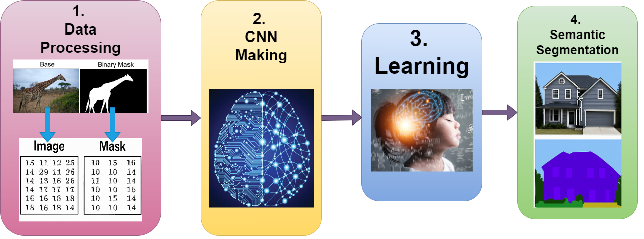

The process for developing a CNN model is demonstrated in the figure.  


1.   First, the images and their equivalent masks should be read and stored into the matrix data structures.

2.   Then, a pre-trained CNN model should be loaded as complex graph data structures.

3.   The CNN model is able to learn the content of images and recognize patterns within them.

4.   The learnt CNN can semantically segment the new images.


In this toolkit, the process can be passed very easily without any programming.

⚠ You should run the cells respectively.



In [ ]:

# @title ## 1. Data Processing


# @markdown Enter the path of the images directory:
image_dir = 'images/'   # @param {type:"string", placeholder:"Path of the images directory"}



# @markdown Enter the path of the masks directory:
mask_dir = 'masks/' # @param {"type":"string","placeholder":"Path of the masks directory"}

# @markdown The names of the masks should be equal to their pair images.


# @markdown :

# @markdown Please enter the size of the images:

Image_Width = 128  # @param {type:"integer"}
Image_Height = 128  # @param {type:"integer"}



image_dataset, mask_dataset = readDataset(image_dir , mask_dir , Image_Width , Image_Height ) ;

x_train , x_test , y_train , y_test = train_test_split(image_dataset, mask_dataset, test_size=0.15 , shuffle = True)






---



In [ ]:
# @title ## 2. CNN Making

Architecture = 'Unet' # @param ["Unet" , "LinkNet" , "FPN" , "PSPNet"]
Backbone = 'ResNet101' # @param  ['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152', 'SeResNet18', 'SeResNet34', 'SeResNet50', 'SeResNet101', 'SeResNet152', 'SeResNEXT50', 'SeResNEXT101', 'SeNet154', 'ResNEXT50', 'ResNEXT101', 'VGG16', 'VGG19', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7']


model = makeModel(Architecture , Backbone , Image_Width , Image_Height) ;





---



In [ ]:
# @title ## 3. Learning

EPOCHS = 100 # @param {type:"integer"}

model.fit(x_train , y_train ,
          batch_size = 16 ,
          epochs = EPOCHS ,
          verbose = 1 ,
          validation_data = ( x_test , y_test ) )   ;




---



In [ ]:
# @title ## 4. Semantic Segmentation

# @markdown Enter the path of the tests directory:
tests_dir = 'tests/'   # @param {type:"string", placeholder:"Path of the images directory"}


raws , images = readTests(tests_dir , Image_Width , Image_Height ) ;


#Testing and asking from the model
results_for_tests = model.predict(images) ;


for k in range(len(results_for_tests)):
          print("Test case:")
          plt.figure(figsize=(10,10)) ;
          plt.subplot(223) ;
          plt.imshow(raws[k]) ;
          plt.subplot(224) ;
          plt.imshow(results_for_tests [k]) ;
          plt.show() ;
          print("_____________________________________") ;





---



**Sina Saadati**



sina.semantic.segmentation@gmail.com

autmedical@gmail.com